Homework 3 - Nikhil Arora (na4063)

Setup: import libraries and set display options used throughout the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

Load, clean, and enrich data

Read the dataset, parse the datetime column, coerce numeric fields (counts and weather), and create helper columns (date, year, weekday, hour). This prepares the DataFrame for all tasks.

In [2]:
DATA_PATH = '/content/Brooklyn_Bridge_Automated_Pedestrian_Counts_Demonstration_Project_20251020.csv'

TS_COL       = 'hour_beginning'
LOC_COL      = 'location'
COUNT_COL    = 'Pedestrians'
WEATHER_COL  = 'weather_summary'
TEMP_COL     = 'temperature'
PRECIP_COL   = 'precipitation'

import pandas as pd, numpy as np

df = pd.read_csv(DATA_PATH, thousands=',')

if not np.issubdtype(df[TS_COL].dtype, np.datetime64):
    df[TS_COL] = pd.to_datetime(df[TS_COL], errors='coerce')
df = df.dropna(subset=[TS_COL]).copy()

for col in [COUNT_COL, TEMP_COL, PRECIP_COL, 'Towards Manhattan', 'Towards Brooklyn']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['date']    = df[TS_COL].dt.date
df['year']    = df[TS_COL].dt.year
df['weekday'] = df[TS_COL].dt.day_name()
df['hour']    = df[TS_COL].dt.hour

print(df.dtypes[[TS_COL, COUNT_COL, TEMP_COL, PRECIP_COL]].dropna())
df.head()

/tmp/ipython-input-1829915073.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[TS_COL] = pd.to_datetime(df[TS_COL], errors='coerce')


hour_beginning    datetime64[ns]
Pedestrians                int64
temperature              float64
precipitation            float64
dtype: object


,hour_beginning,location,Pedestrians,Towards Manhattan,Towards Brooklyn,weather_summary,temperature,precipitation,lat,long,events,Location1,date,year,weekday,hour
0,2019-04-30 00:00:00,Brooklyn Bridge,3,3,0,NaN,NaN,NaN,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)",2019-04-30,2019,Tuesday,0
1,2019-12-31 22:00:00,Brooklyn Bridge,10,9,1,cloudy,42.0,0.0005,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)",2019-12-31,2019,Tuesday,22
2,2019-12-31 23:00:00,Brooklyn Bridge,2,0,2,cloudy,42.0,0.0004,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)",2019-12-31,2019,Tuesday,23
3,2019-12-31 21:00:00,Brooklyn Bridge,12,0,12,cloudy,42.0,0.0036,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)",2019-12-31,2019,Tuesday,21
4,2019-04-01 03:00:00,Brooklyn Bridge,1,0,1,clear-night,36.0,0.0000,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)",2019-04-01,2019,Monday,3


Task 1 — Weekdays (Mon–Fri): line plot of pedestrian counts

Filter to Monday–Friday, aggregate total pedestrians by weekday, and plot a line chart.

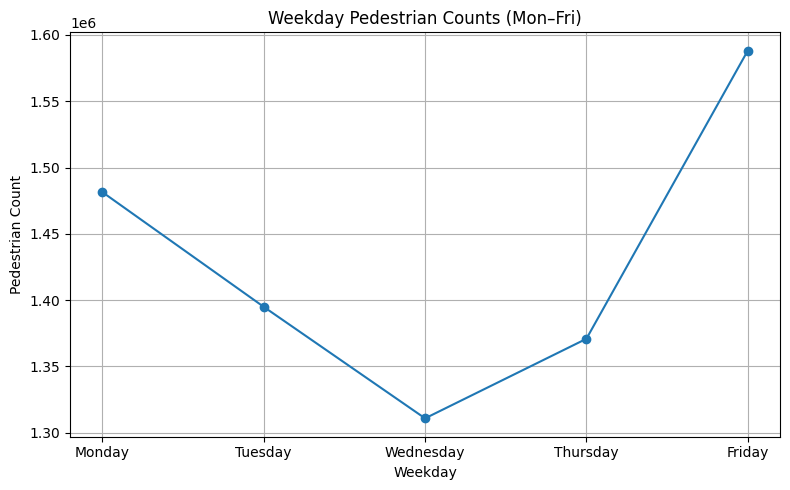

,weekday,Pedestrians
1,Monday,1481435
3,Tuesday,1394963
4,Wednesday,1310900
2,Thursday,1370880
0,Friday,1588068


In [3]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_weekdays = df[df['weekday'].isin(weekdays)].copy()

weekday_summary = (
    df_weekdays
    .groupby('weekday', as_index=False)[COUNT_COL]
    .sum()
)

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekday_summary['weekday'] = pd.Categorical(weekday_summary['weekday'], categories=order, ordered=True)
weekday_summary = weekday_summary.sort_values('weekday')

plt.figure(figsize=(8, 5))
plt.plot(weekday_summary['weekday'], weekday_summary[COUNT_COL], marker='o')
plt.title('Weekday Pedestrian Counts (Mon–Fri)')
plt.xlabel('Weekday')
plt.ylabel('Pedestrian Count')
plt.grid(True)
plt.tight_layout()
plt.show()

weekday_summary


Task 2 — 2019, Brooklyn Bridge: weather effects

Filter to the Brooklyn Bridge in 2019 and compare mean pedestrian counts by weather_summary. The bar chart shows how activity varies by weather category.

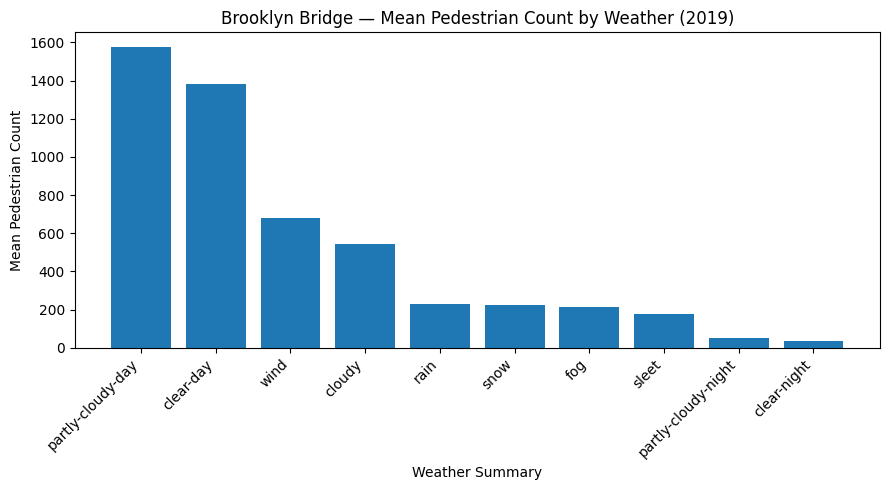

,weather_summary,Pedestrians
4,partly-cloudy-day,1574.093627
0,clear-day,1382.183298
9,wind,679.000000
2,cloudy,543.225041
6,rain,229.822076
8,snow,222.631579
3,fog,212.409091
7,sleet,178.250000
5,partly-cloudy-night,52.765922
1,clear-night,33.233871


In [4]:
BRIDGE_NAME = 'Brooklyn Bridge'
YEAR = 2019

if WEATHER_COL is None:
    raise ValueError("No weather column detected. Set WEATHER_COL to your weather-summary column name.")

df_2019_bk = df[(df['year'] == YEAR) & (df[LOC_COL] == BRIDGE_NAME)].copy()

mean_by_weather = (
    df_2019_bk
    .groupby(WEATHER_COL, as_index=False)[COUNT_COL]
    .mean()
    .sort_values(COUNT_COL, ascending=False)
)

plt.figure(figsize=(9, 5))
plt.bar(mean_by_weather[WEATHER_COL].astype(str), mean_by_weather[COUNT_COL])
plt.title(f'{BRIDGE_NAME} — Mean Pedestrian Count by Weather ({YEAR})')
plt.xlabel('Weather Summary')
plt.ylabel('Mean Pedestrian Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

mean_by_weather


Task 2 — Correlation matrix

Create a correlation matrix between pedestrian counts and weather variables by one-hot encoding weather_summary and including numeric weather features (e.g., temperature, precipitation, lat/long).

In [5]:
dummies = pd.get_dummies(df_2019_bk[WEATHER_COL].astype(str), prefix='wx', drop_first=False)

possible_numeric = [c for c in df_2019_bk.columns if c not in [TS_COL, LOC_COL, COUNT_COL, WEATHER_COL, 'date', 'year', 'weekday', 'hour']]
numeric_weather = []
for c in possible_numeric:
    if pd.api.types.is_numeric_dtype(df_2019_bk[c]):
        numeric_weather.append(c)

corr_base = pd.concat([
    df_2019_bk[[COUNT_COL]].reset_index(drop=True),
    dummies.reset_index(drop=True),
    df_2019_bk[numeric_weather].reset_index(drop=True) if numeric_weather else pd.DataFrame(index=df_2019_bk.index)
], axis=1)

corr = corr_base.corr(numeric_only=True)

out_csv = '/content/correlation_matrix_2019_brooklyn_bridge.csv'
corr.to_csv(out_csv, index=True)
print('Correlation matrix saved to:', out_csv)

corr


Correlation matrix saved to: /content/correlation_matrix_2019_brooklyn_bridge.csv


,Pedestrians,wx_clear-day,wx_clear-night,wx_cloudy,wx_fog,wx_nan,wx_partly-cloudy-day,wx_partly-cloudy-night,wx_rain,wx_sleet,wx_snow,wx_wind,Towards Manhattan,Towards Brooklyn,temperature,precipitation,lat,long
Pedestrians,1.000000,0.339758,-0.377297,-0.081255,-0.026457,-0.030466,0.497867,-0.282081,-0.138581,-0.017091,-0.034052,-0.000170,0.989069,0.991341,0.358757,-0.105432,NaN,NaN
wx_clear-day,0.339758,1.000000,-0.227660,-0.224004,-0.022002,-0.017544,-0.220884,-0.175456,-0.119645,-0.013257,-0.028943,-0.009372,0.344511,0.329275,0.012629,-0.082876,NaN,NaN
wx_clear-night,-0.377297,-0.227660,1.000000,-0.265198,-0.026048,-0.020770,-0.261504,-0.207722,-0.141648,-0.015695,-0.034266,-0.011096,-0.377552,-0.370129,-0.214628,-0.099281,NaN,NaN
wx_cloudy,-0.081255,-0.224004,-0.265198,1.000000,-0.025630,-0.020436,-0.257304,-0.204386,-0.139373,-0.015443,-0.033715,-0.010917,-0.085169,-0.076275,-0.083671,-0.069079,NaN,NaN
wx_fog,-0.026457,-0.022002,-0.026048,-0.025630,1.000000,-0.002007,-0.025273,-0.020075,-0.013690,-0.001517,-0.003312,-0.001072,-0.027081,-0.025414,-0.026764,0.001323,NaN,NaN
wx_nan,-0.030466,-0.017544,-0.020770,-0.020436,-0.002007,1.000000,-0.020152,-0.016007,-0.010915,-0.001209,-0.002641,-0.000855,-0.030818,-0.029592,NaN,NaN,NaN,NaN
wx_partly-cloudy-day,0.497867,-0.220884,-0.261504,-0.257304,-0.025273,-0.020152,1.000000,-0.201539,-0.137432,-0.015228,-0.033246,-0.010765,0.497835,0.488737,0.314094,-0.092704,NaN,NaN
wx_partly-cloudy-night,-0.282081,-0.175456,-0.207722,-0.204386,-0.020075,-0.016007,-0.201539,1.000000,-0.109167,-0.012096,-0.026408,-0.008551,-0.283213,-0.275885,0.009320,-0.072337,NaN,NaN
wx_rain,-0.138581,-0.119645,-0.141648,-0.139373,-0.013690,-0.010915,-0.137432,-0.109167,1.000000,-0.008249,-0.018008,-0.005831,-0.136818,-0.137603,-0.016712,0.616275,NaN,NaN
wx_sleet,-0.017091,-0.013257,-0.015695,-0.015443,-0.001517,-0.001209,-0.015228,-0.012096,-0.008249,1.000000,-0.001995,-0.000646,-0.017534,-0.016382,-0.035462,0.031190,NaN,NaN


Task 3 — Time-of-day categories

Define a custom function to bucket hours into Night (0–5), Morning (6–11), Afternoon (12–17), Evening (18–23). Add a new column and compare average pedestrian activity across these buckets with a bar chart.

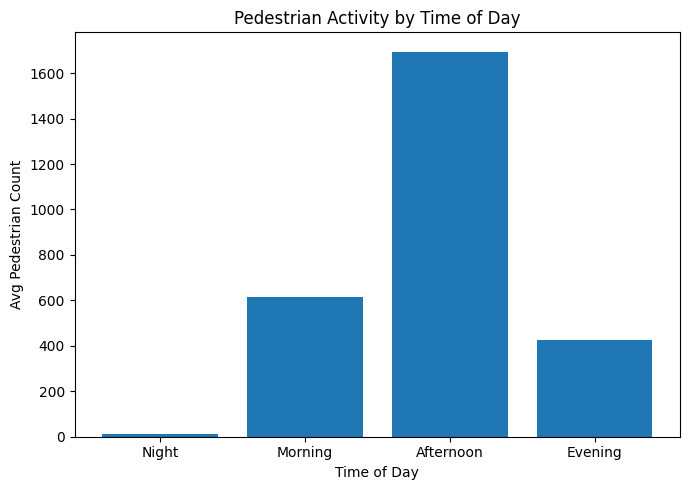

,time_of_day,Pedestrians
3,Night,13.001993
2,Morning,614.543099
0,Afternoon,1694.841305
1,Evening,426.206776


In [6]:
def time_of_day_bucket(h):
    if 0 <= h <= 5:
        return 'Night'
    elif 6 <= h <= 11:
        return 'Morning'
    elif 12 <= h <= 17:
        return 'Afternoon'
    else:
        return 'Evening'

df['time_of_day'] = df['hour'].apply(time_of_day_bucket)

tod_summary = (
    df.groupby('time_of_day', as_index=False)[COUNT_COL]
      .mean()
)

order = ['Night', 'Morning', 'Afternoon', 'Evening']
tod_summary['time_of_day'] = pd.Categorical(tod_summary['time_of_day'], categories=order, ordered=True)
tod_summary = tod_summary.sort_values('time_of_day')

plt.figure(figsize=(7, 5))
plt.bar(tod_summary['time_of_day'].astype(str), tod_summary[COUNT_COL])
plt.title('Pedestrian Activity by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Avg Pedestrian Count')
plt.tight_layout()
plt.show()

tod_summary
